In [1]:
from dataset import PerformanceChunks
import torch
import pandas as pd

import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np

from model import Model

In [3]:
class Config:
    def __init__(self, iterable=(), **kwargs):
        self.__dict__.update(iterable, **kwargs)

In [5]:
config = Config({
    "meta_csv": "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_annotations_single_1.csv",
    "dataset_dir": "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_features",
    "feature_type": "cqt",
    "time_axis": 1,
    "hop_length": 42,
    "frames_per_sample": 64,
    "dataset_cache_limit": 80,
    "workers": 1,
    "device": "cpu",
    "input_size": 84,
    "hidden_size": 128,
    "batch_size": 1024,
    "model_layers": 2,
})

FREQUENCY IS  0.01179245283018868
Input  torch.Size([100, 64, 84])
Embeddings  torch.Size([100, 128])
Decoder Input 0 torch.Size([100, 1, 84])
Decoder state torch.Size([2, 100, 128]) torch.Size([2, 100, 128])
Decoder outputs  torch.Size([100, 64, 84])
With random decoder inputs
torch.Size([100, 64, 84])


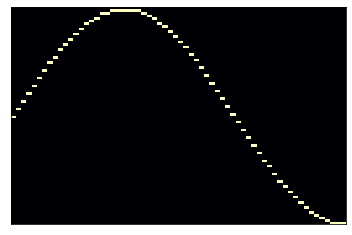

In [6]:
dataset = PerformanceChunks(
    dataset_meta_csv_path=config.meta_csv,
    base_dir=config.dataset_dir,
    feature_type=config.feature_type,
    time_axis=config.time_axis,
    hop_length=config.hop_length,
    frames_per_sample=config.frames_per_sample,
    cache_limit=config.dataset_cache_limit
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.batch_size, num_workers=config.workers, shuffle=False)

device = torch.device(config.device)
model = Model(input_size=config.input_size, layers=config.model_layers, share_weights=False,
              embedding_size=config.hidden_size).to(device)

model.train()

for i, (sequence) in enumerate(dataloader):
    sequence = sequence.to(device)
    (embeddings, pred) = model(sequence)
    print(pred.shape)

source = sequence[0] # pred[0]
data=source.detach().numpy().transpose()
librosa.display.specshow(data)

In [9]:
# LogSoftmax dimension test
d = torch.tensor([[1000.,0.,0.], [0.,1.,0.], [0.,0.,1.]])
m = torch.nn.LogSoftmax(dim=1)
m(d)

tensor([[ 0.0000e+00, -1.0000e+03, -1.0000e+03],
        [-1.5514e+00, -5.5144e-01, -1.5514e+00],
        [-1.5514e+00, -1.5514e+00, -5.5144e-01]])

In [ ]:
# Sine wave generation
cqt_coefficients, samples = 84, 4200
freq = 5/4200

steps = np.linspace(0, samples, samples, endpoint=False)
wave = np.sin(2 * np.pi * freq * steps)

wave = ((wave + 1.0) * ((cqt_coefficients-1)/2))
wave = np.floor(wave).astype(int)
plot = np.zeros((cqt_coefficients, samples))

for (index, value) in enumerate(wave):
  plot[value, index] = 1.0

librosa.display.specshow(plot)


In [9]:
# Pytorch View test
d = torch.tensor([[[1,2,4], [8, 16, 32]], [[64,128, 256], [512, 1024, 2048]]])

In [12]:
d


tensor([[[   1,    2,    4],
         [   8,   16,   32]],

        [[  64,  128,  256],
         [ 512, 1024, 2048]]])

In [13]:
d.view(-1, 3)

tensor([[   1,    2,    4],
        [   8,   16,   32],
        [  64,  128,  256],
        [ 512, 1024, 2048]])

In [14]:
d.view(-1, d.shape[-1])

tensor([[   1,    2,    4],
        [   8,   16,   32],
        [  64,  128,  256],
        [ 512, 1024, 2048]])

In [18]:
def test(a):
  b = a*a
  def test2(v):
    return v * b
  return test2


In [19]:
fn = test(10)

In [20]:
fn(10)

1000

# Evaluator Tests

In [6]:
config = Config({
    "meta_csv": "/Users/pasinduwijesena/Downloads/Research-Datasets/covers80/covers80_annotations_single_1.csv",
    "dataset_dir": "/Users/pasinduwijesena/Downloads/Research-Datasets/covers80/covers80_features",
    "feature_type": "cqt",
    "time_axis": 1,
    "hop_length": 42,
    "frames_per_sample": 64,
    "dataset_cache_limit": 80,
    "workers": 1,
    "device": "cpu",
    "input_size": 84,
    "hidden_size": 128,
    "batch_size": 512,
    "model_layers": 2,
})

In [7]:
dataset = PerformanceChunks(
    dataset_meta_csv_path=config.meta_csv,
    base_dir=config.dataset_dir,
    feature_type=config.feature_type,
    time_axis=config.time_axis,
    hop_length=config.hop_length,
    frames_per_sample=config.frames_per_sample,
    cache_limit=config.dataset_cache_limit
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.batch_size, num_workers=config.workers, shuffle=False)

device = torch.device(config.device)
model = Model(input_size=config.input_size, layers=config.model_layers, share_weights=False,
              embedding_size=config.hidden_size).to(device)

In [14]:
def build_reference_db(model, dataloader, device, hash_fn):
  model.eval()
  db = []

  with torch.no_grad():
    for i, (sequence, sequence_indices, work_id, track_id) in enumerate(dataloader):
      sequence = sequence.to(device)
      embeddings = model(sequence)

      # convert the embeddings to hashes
      hashes = hash_fn(embeddings.detach().numpy())
      print(hashes.shape)
      # save the hashes
      for (index, hash) in enumerate(hashes): 
        db.append([work_id[index], track_id[index], hash])
  
  return db


def hash_fn(embeddings):
  def threshold(value):
    if value > 0.0:
      return True
    return False
  
  vectorized_threshold = np.vectorize(threshold)
  return vectorized_threshold(embeddings).astype(bool)


ref_db = build_reference_db(model, dataloader, device, hash_fn)

(100, 128)


In [16]:
len(ref_db)

100